<a href="https://colab.research.google.com/github/kishanAk21/Restricted_Boltzmann_Machine_for_Reco_Sys/blob/main/main_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement¶
Aim of this exercise is to get initial insights of the online purchase dataset and recommend related products to user based on similar other users. 

We would be using Restricted Boltzmann Machines (RBMs) algorithm for developing recommender system model. The process for developing recommender system using RBMs is highlighed here.

- Data Cleaning and Pre-processing: Initially we would clean and pre-process the dataset to make it ready for model training purpose.
- Model Functions: We would develop a few functions that would be useful in model training.
- Model Training: This step includes training the model with batches. It includes updating weights, hidden bias and visible bias parameters.
- Model testing: We would select one test case to illustrate model's performance on it. 


You can learn the basic theory behind RBMs here. https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine

You can check out this practical guide on training RBMs here. https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf


In [1]:
# Dependencies

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# Mouting Gdrive for data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Reading Dataset from Gdrive

data = pd.read_csv('/content/drive/MyDrive/sample30.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


Here we only need columns 'name' --> Product Name, 'reviews_username' --> User Name, and 'reviews_rating' --> Rating. We would drop other columns as they would not add any value to our model.

In [4]:
# Redefining ratings data
ratings = data[['name', 'reviews_username', 'reviews_rating']]

# dropping rows with null entires in 'reviews_username' column
ratings = ratings.dropna(axis=0,
                        subset = ['reviews_username'])

ratings.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1


There might be some duplucate data entry as well. We would make sure to avoid them as they can create data duplication and overfitting problems.

In [5]:
# dropping duplicate rows (except first entry)

ratings.drop_duplicates(inplace=True)
ratings.shape

(27739, 3)

In [6]:
# Keep last in case of multiple ratings by a user for the same product

ratings.drop_duplicates(subset = ['name', 'reviews_username'], keep='last', inplace=True)
ratings.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1
5,K-Y Love Sensuality Pleasure Gel,samantha,1


In [7]:
ratings.shape

(27588, 3)

Label encoding helps converting string based data into numeric entries.

In [8]:
# label_encoder1
label_encoder1 = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
ratings['reviews_username'] = label_encoder1.fit_transform(ratings['reviews_username'])


# label_encoder2
label_encoder2 = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
ratings['name'] = label_encoder2.fit_transform(ratings['name'])


ratings.head()

,name,reviews_username,reviews_rating
0,182,11440,5
1,140,6974,5
3,120,19327,1
4,120,24205,1
5,120,20202,1


In [9]:
# Defining User-Product dataframe

user_rating_df = ratings.pivot(index='reviews_username', columns='name', values='reviews_rating')
user_rating_df.head()

name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here, we want to convert the explicit ratings into implicit for better learning by RBM algorithm. We woud map null, 1s and 2s to 0 and 3s, 4s, and 5s to 1. This basicaly means a product is liked by a user only if rating provided is 3 or above.

In [10]:
# Normalizing dataframe

norm_user_rating_df = user_rating_df.fillna(0)
norm_user_rating_df = norm_user_rating_df.replace({1:0, 2:0, 3:1, 4:1, 5:1})

trainingset, testset = train_test_split(norm_user_rating_df, train_size=0.75, random_state=2021)
print(len(trainingset), len(testset))


trX = trainingset.values
trX[0:5]


trX_test = testset.values
trX_test[0:5]

18685 6229


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
# Defining hidden layer bias, visible layer bias and weights

hiddenUnits = 64
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) # visible layer bias
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) # hidden layer bias

weight_initer = tf.initializers.RandomNormal(stddev=0.01)
W = tf.Variable(weight_initer(shape=(visibleUnits, hiddenUnits)))

In [12]:
# Printing W (weight array)

W

<tf.Variable 'Variable:0' shape=(271, 64) dtype=float32, numpy=
array([[ 0.00594306, -0.01657118,  0.01479729, ..., -0.00099151,
        -0.00794878,  0.00388871],
       [ 0.00158777, -0.00798872,  0.00264803, ..., -0.0069291 ,
        -0.0023272 , -0.00813745],
       [-0.00176481, -0.01023013,  0.01173166, ...,  0.01245588,
        -0.00422298, -0.00809119],
       ...,
       [ 0.010889  ,  0.00513617,  0.00681206, ...,  0.00090404,
        -0.00587797,  0.00664763],
       [ 0.01067833, -0.00361977, -0.01190201, ..., -0.01740669,
        -0.00549102,  0.00575118],
       [-0.0036224 ,  0.00826171,  0.0071958 , ...,  0.01395154,
         0.01379385, -0.00311616]], dtype=float32)>

Let's define functions to be used while model training process. 

In [13]:
# defining a function to return generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.reshape(tf.nn.sigmoid(tf.matmul(v0_state, W) + hb), [-1,hiddenUnits])  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

# Defining function to return recalculated visible states 
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state

# Defining function for RMSE
def error(v0_state, v1_state):
    return tf.math.reduce_mean(tf.math.sqrt(tf.reduce_mean(tf.square(v0_state - v1_state))))

epoch: 1 Train reconstruction error: 0.120163545 validation reconstruction error: 0.11777756
epoch: 2 Train reconstruction error: 0.09936866 validation reconstruction error: 0.10055064
epoch: 3 Train reconstruction error: 0.09744187 validation reconstruction error: 0.09392217
epoch: 4 Train reconstruction error: 0.09173668 validation reconstruction error: 0.090301365
epoch: 5 Train reconstruction error: 0.09205411 validation reconstruction error: 0.087779835
epoch: 6 Train reconstruction error: 0.0865838 validation reconstruction error: 0.086747974
epoch: 7 Train reconstruction error: 0.08808681 validation reconstruction error: 0.08567258
epoch: 8 Train reconstruction error: 0.086667985 validation reconstruction error: 0.0844819
epoch: 9 Train reconstruction error: 0.08539651 validation reconstruction error: 0.0838449
epoch: 10 Train reconstruction error: 0.085907355 validation reconstruction error: 0.0831781
epoch: 11 Train reconstruction error: 0.08808681 validation reconstruction er

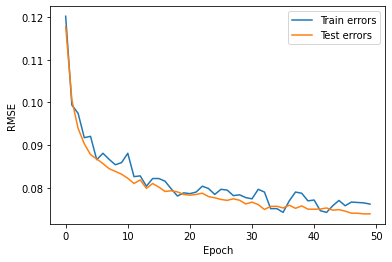

In [14]:
# Training hyper-parameters
epochs = 50
batchsize = 256
errors = []
errors_test = []
weights = []
alpha = 0.001

# creating datasets
train_ds = tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)

# Model Training
for epoch in range(epochs):
    for batch_x in train_ds:
        v0_state = batch_x
        h0_state = hidden_layer(v0_state, W, hb)
        v1_state = reconstructed_output(h0_state, W, vb)
        h1_state = hidden_layer(v1_state, W, hb)

        delta_W = tf.matmul(tf.transpose(v0_state), h0_state) - tf.matmul(tf.transpose(v1_state), h1_state)
        W = W + alpha * delta_W

        vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
        hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

        v0_state = v1_state

        err_train = error(batch_x, v1_state)

    # Train 
    errors.append(err_train.numpy())
    
    # Validation (testset)
    inputUser = tf.convert_to_tensor(trX_test,"float32")
    hh0 = hidden_layer(inputUser, W, hb)
    vv1 = reconstructed_output(hh0, W, vb)

    err_test = error(inputUser, vv1)
    errors_test.append(err_test.numpy())

    print ('epoch:', epoch+1, 'Train reconstruction error:', err_train.numpy(), 'validation reconstruction error:', err_test.numpy())
    

plt.plot(errors)
plt.plot(errors_test)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(["Train errors", "Test errors"], loc ="upper right")
plt.show()

Now we would check the model performance on one of the test (validation) case.

In [15]:
# Test user case

mock_user_id = 201

In [16]:
# Selecting the input user

inputUser = tf.convert_to_tensor(testset[testset.index == mock_user_id].values,"float32")
v0 = inputUser

print(v0)
v0.shape

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 271), dtype=float32)


TensorShape([1, 271])

In [17]:
# Feeding in the user and reconstructing the input

hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
rec = vv1

In [18]:
scored_movies_df_mock = pd.DataFrame(list(zip(user_rating_df.columns, list(rec[0].numpy()))), columns=['name', 'proba'])
scored_movies_df_mock.sort_values('proba', ascending=False).head(20)

,name,proba
93,93,0.063248
64,64,0.048263
183,183,0.047822
41,41,0.039103
171,171,0.034307
200,200,0.032343
239,239,0.031994
151,151,0.031971
129,129,0.030153
157,157,0.023664


In [19]:
prod_df_mock = ratings[ratings['reviews_username'] == mock_user_id]
prod_df_mock

,name,reviews_username,reviews_rating
87,171,201,3


In [20]:
# Merging prod_df_mock with ratings_df by 'name'

merged_df_mock = scored_movies_df_mock.merge(prod_df_mock, on ='name', how='outer')

In [21]:
merged_df_mock['product_name'] = label_encoder2.inverse_transform(merged_df_mock['name'])
merged_df_mock.sort_values('proba', ascending=False).head(20)

,name,proba,reviews_username,reviews_rating,product_name
93,93,0.063248,NaN,NaN,Godzilla 3d Includes Digital Copy Ultraviolet ...
64,64,0.048263,NaN,NaN,Clorox Disinfecting Bathroom Cleaner
183,183,0.047822,NaN,NaN,Planes: Fire Rescue (2 Discs) (includes Digita...
41,41,0.039103,NaN,NaN,"Burt's Bees Lip Shimmer, Raisin"
171,171,0.034307,201.0,3.0,Olay Regenerist Deep Hydration Regenerating Cream
200,200,0.032343,NaN,NaN,Red (special Edition) (dvdvideo)
239,239,0.031994,NaN,NaN,The Resident Evil Collection 5 Discs (blu-Ray)
151,151,0.031971,NaN,NaN,Mike Dave Need Wedding Dates (dvd + Digital)
129,129,0.030153,NaN,NaN,L'or233al Paris Elvive Extraordinary Clay Reba...
157,157,0.023664,NaN,NaN,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...


It can be observed that,
- User '201' has already purchased item '171'. Item '171' is having higher probability value as per our model, which is a good sign.
- Apart from item '171', other items can be recommended to user '201' as per our model.

-------------